In [1]:
!pwd


/home/ec2-user/SageMaker


In [2]:
cd lag-llama/


/home/ec2-user/SageMaker/lag-llama


In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [4]:
!pip install -r requirements.txt

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached wandb-0.16.6-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached gluonts-0.14.4-py3-none-any.whl.metadata (9.5 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached lightning-2.1.4-py3-none-any.whl.metadata (57 kB)
  Using cached pytorch_lightning-2.1.4-py3-none-any.whl.metadata (21 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached sentry_sdk-1.45.0-py2.py3-none-any.whl.metadata (9.9 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached Inquirer

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

In [7]:
dataset = get_dataset("m4_weekly")

In [9]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = "cuda"

In [10]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

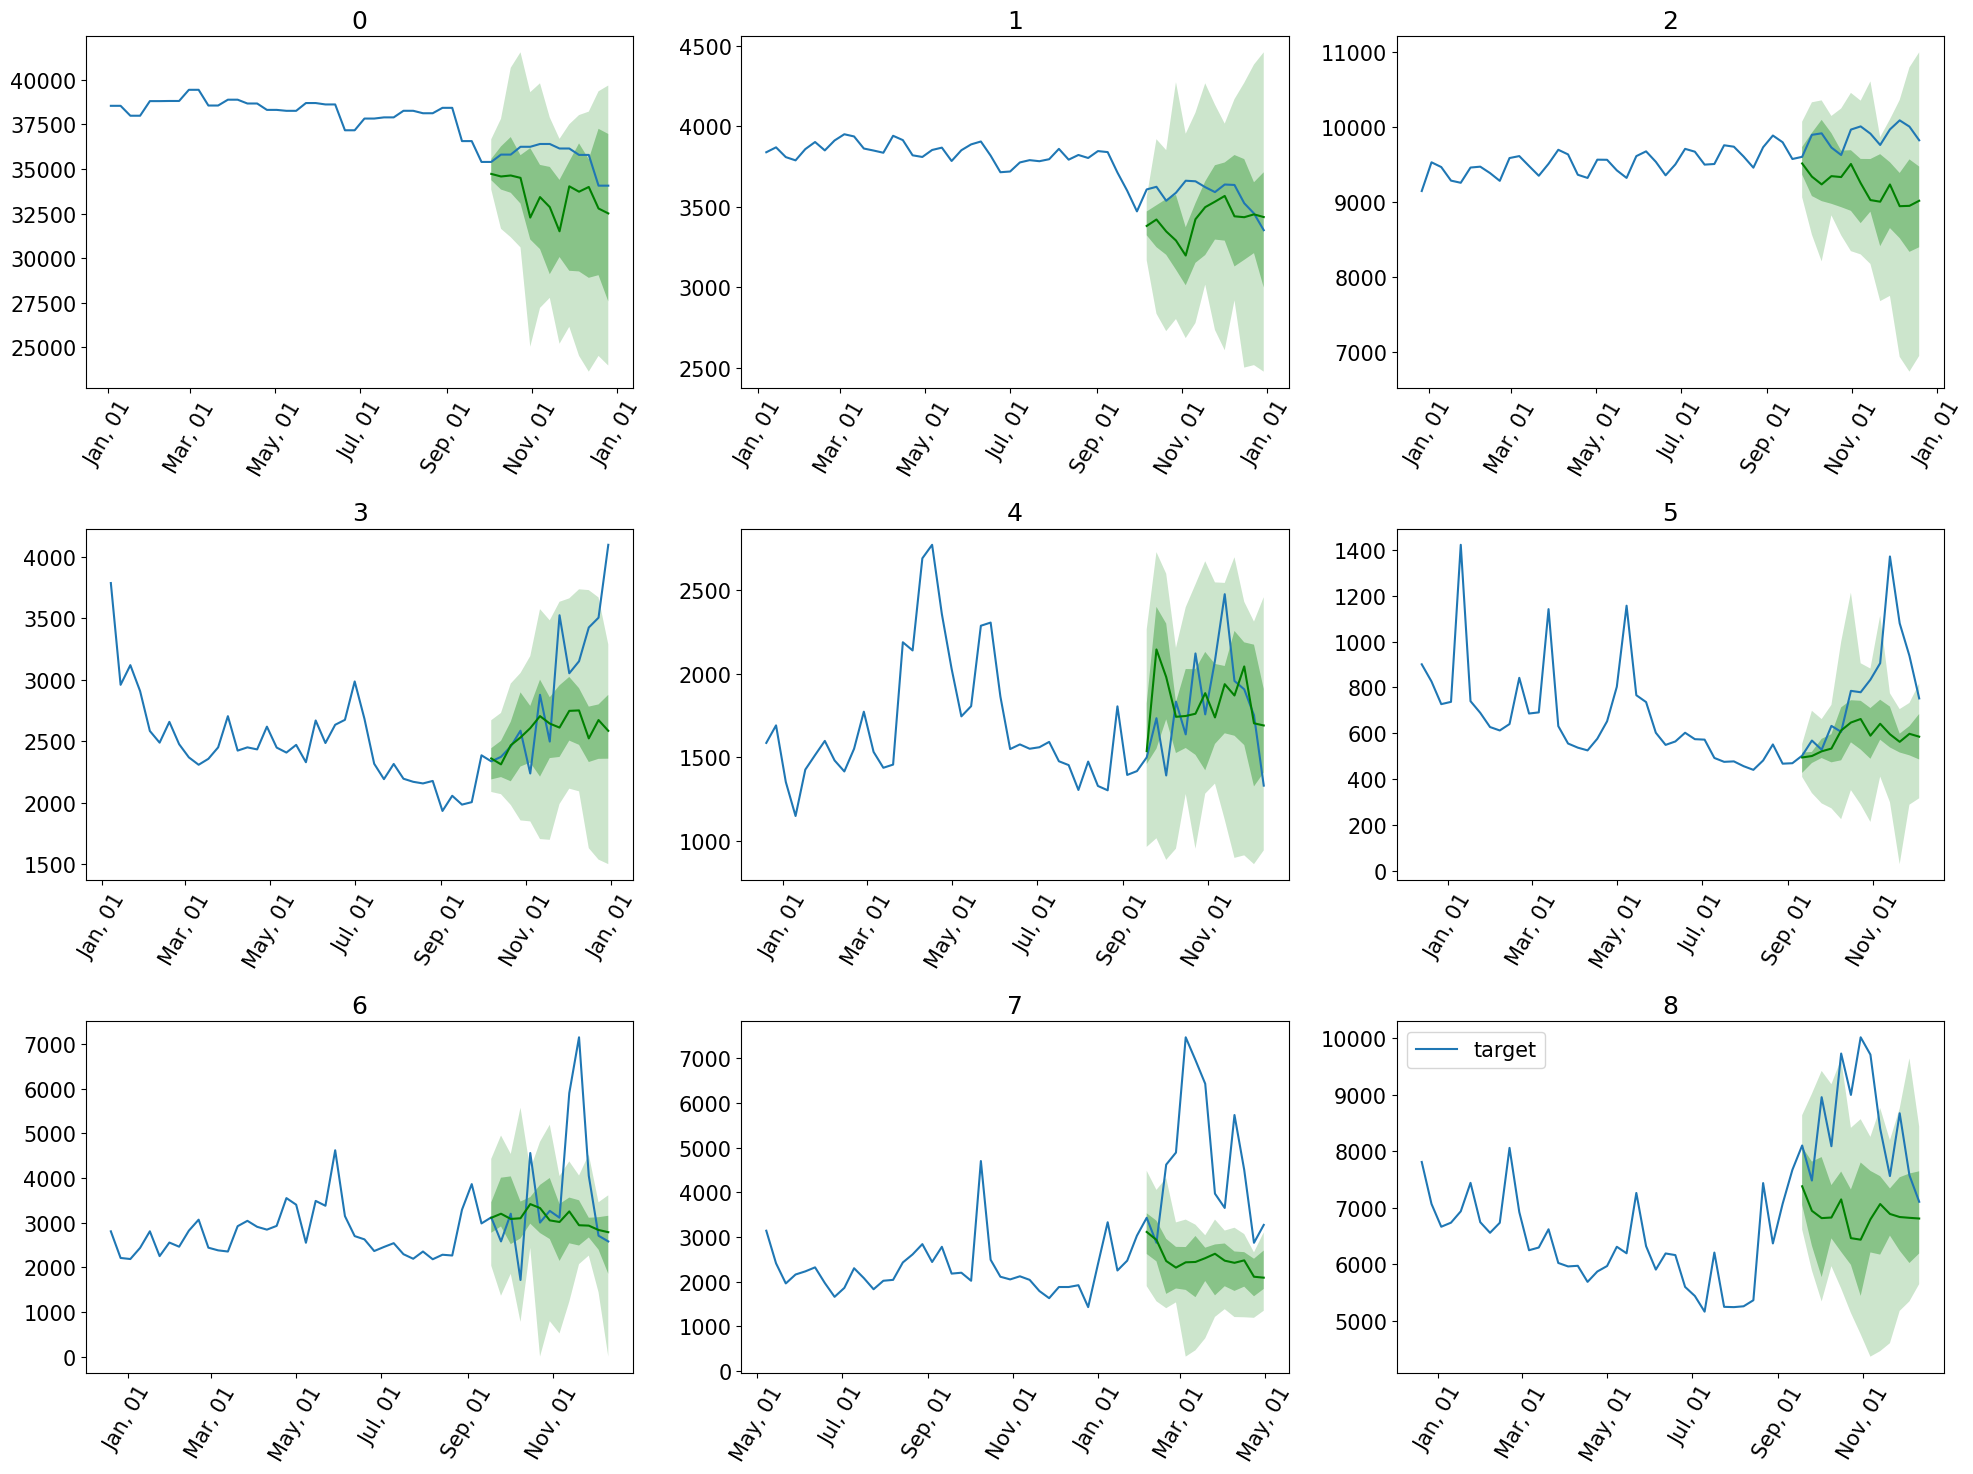

In [11]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [12]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [13]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly uti

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.27975 (best 8.27975), saving model to '/home/ec2-user/SageMaker/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.42068 (best 7.42068), saving model to '/home/ec2-user/SageMaker/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.80571 (best 6.80571), saving model to '/home/ec2-user/SageMaker/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.74598 (best 6.74598), saving model to '/home/ec2-user/SageMaker/lag-llama/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.56217 (best 6.56217), saving model to '/home/ec2-user/SageMaker/lag-llama/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' rea

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [15]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

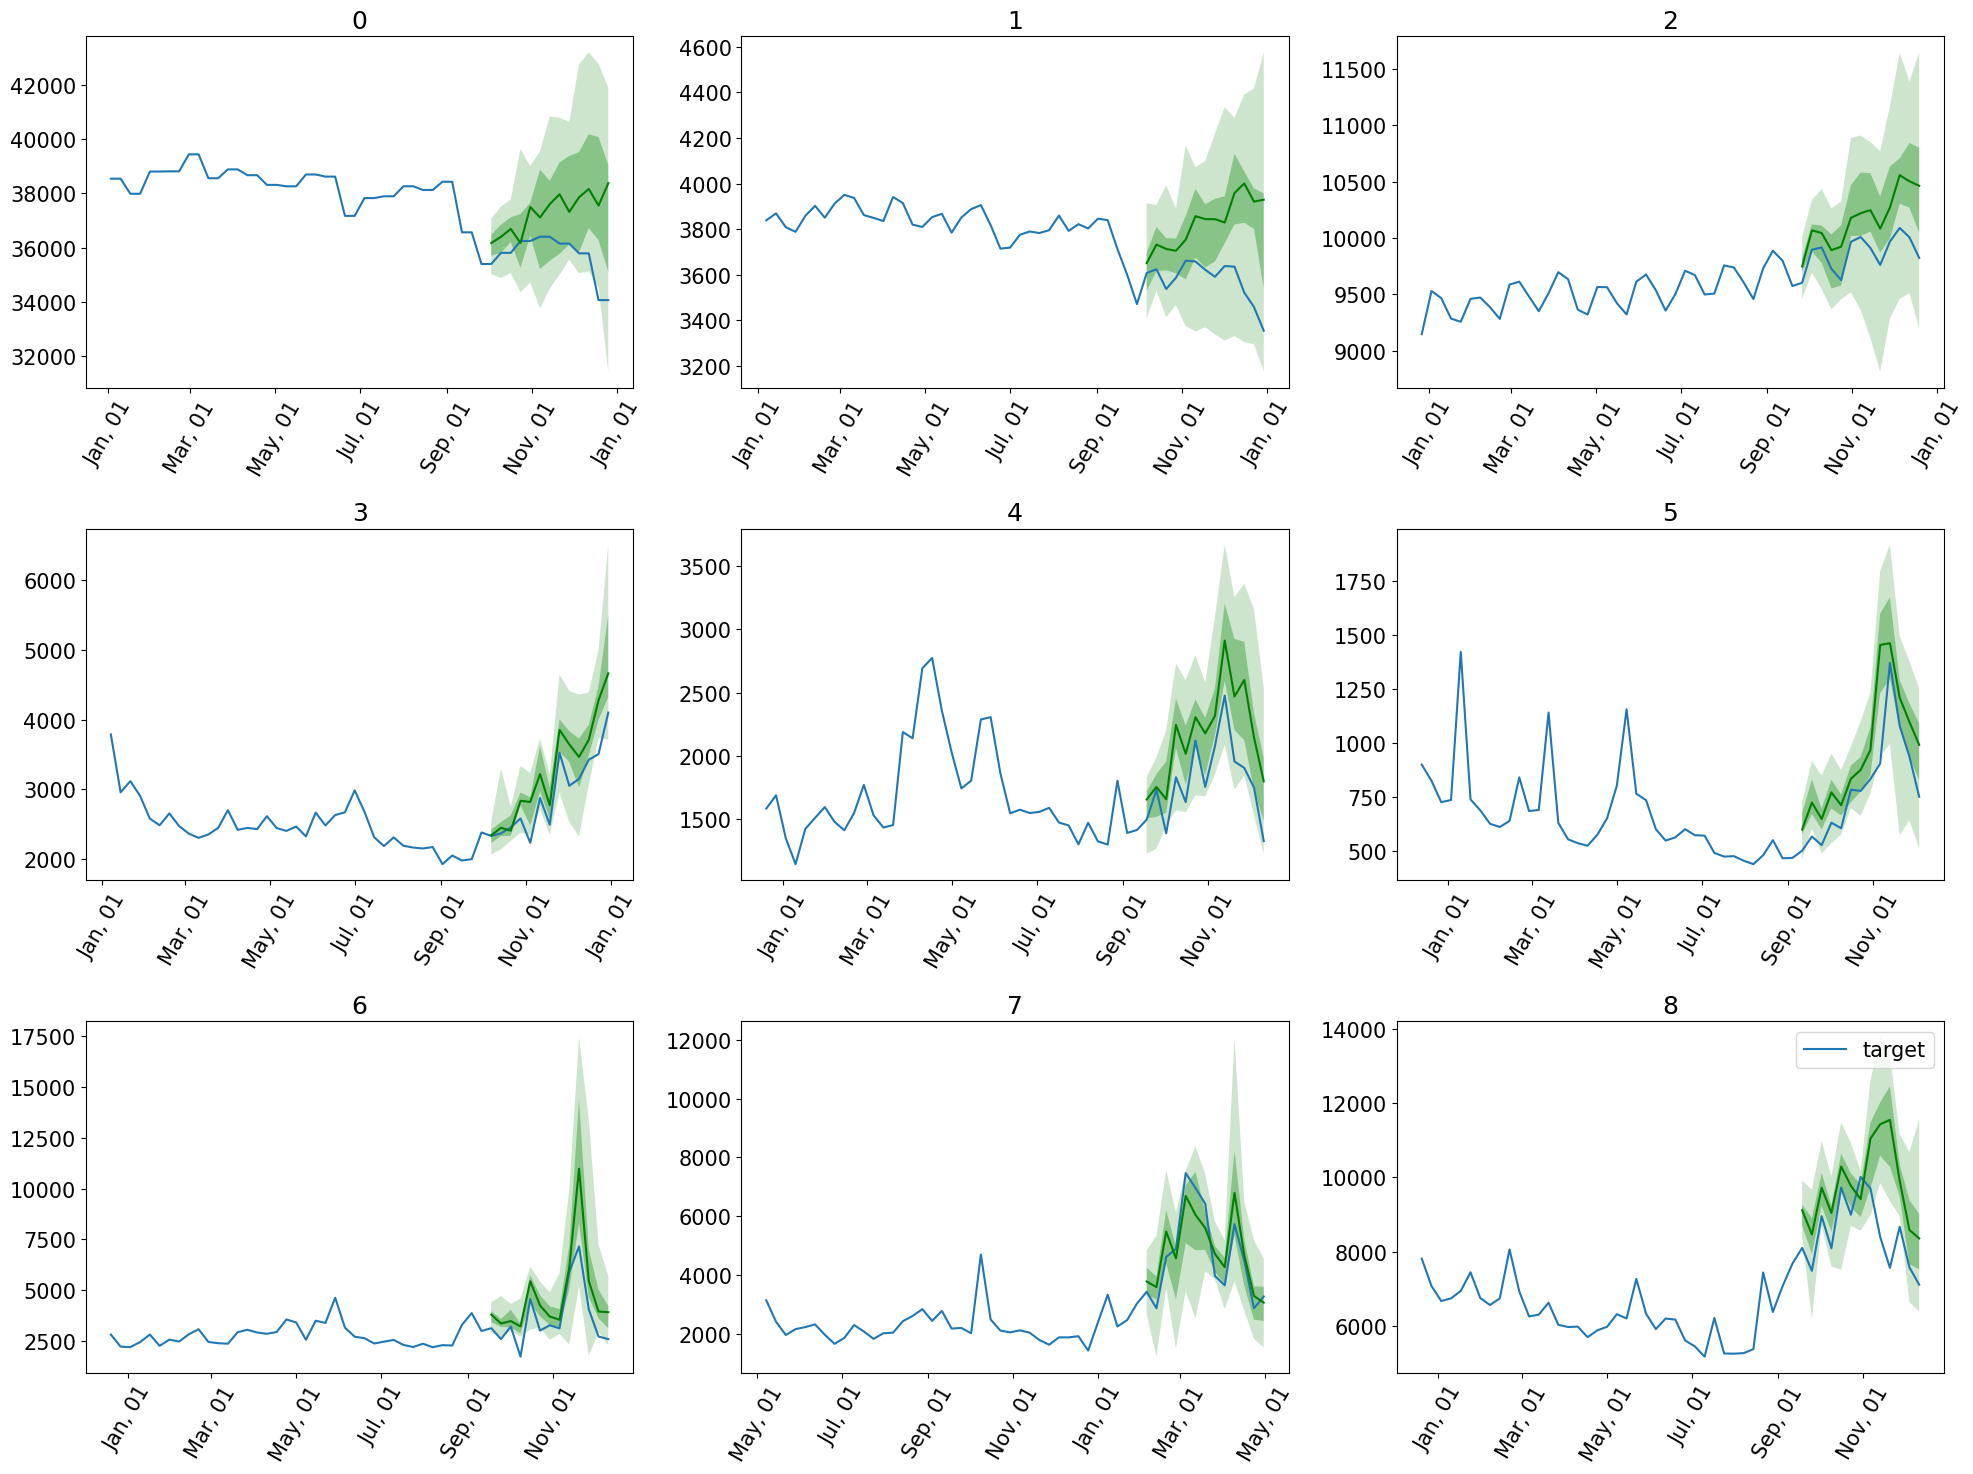

In [17]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 359it [00:00, 8667.66it/s]


In [19]:
agg_metrics

{'MSE': 856844.8968097564,
 'abs_error': 2533471.062194824,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 7.069934692132121,
 'MAPE': 0.17926529437169444,
 'sMAPE': 0.1457383268320614,
 'MSIS': 54.29746865975494,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1197991.668911743,
 'Coverage[0.1]': 0.3169059352903364,
 'QuantileLoss[0.2]': 1797796.9455566409,
 'Coverage[0.2]': 0.444396828797943,
 'QuantileLoss[0.3]': 2193958.837425232,
 'Coverage[0.3]': 0.5553889007928006,
 'QuantileLoss[0.4]': 2427672.9039733885,
 'Coverage[0.4]': 0.6428112277694451,
 'QuantileLoss[0.5]': 2533471.054336548,
 'Coverage[0.5]': 0.7094493250482109,
 'QuantileLoss[0.6]': 2406574.2033691406,
 'Coverage[0.6]': 0.7394471823441184,
 'QuantileLoss[0.7]': 2218967.4037384037,
 'Coverage[0.7]': 0.8002999785729591,
 'QuantileLoss[0.8]': 1868806.2481018063,
 'Coverage[0.8]': 0.8555817441611314,
 'QuantileLoss[0.9]': 1280746.8094696